Core Libraries:

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, get_worker_info
import timm
from timm.data import Mixup
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
from tqdm.notebook import tqdm
import gc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage import rotate
import itertools
%matplotlib inline
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import accuracy_score,roc_curve,auc
from sklearn.preprocessing import label_binarize
from PIL import Image
sns.set(style='white', context='notebook', palette='deep')

WikiArt Dataset:

In [2]:
# Load and map genres, styles classes
datapath = '/kaggle/input/wikiart'
genres_datapath = '/kaggle/input/genres-ds'
styles_datapath = '/kaggle/input/style-ds'

def process_classes(data_path,file_name):
    file_path =  data_path+'/'+file_name+'.txt'
    classes = {}
    with open(file_path, 'r') as f:
        for line in f:
            index, label = line.strip().split(' ', 1)
            classes[int(index)] = label
    return classes

genres_classes = process_classes(genres_datapath,'genre_class')
styles_classes = process_classes(styles_datapath,'style_class')
print(f"Genres:\n{genres_classes}\n")
print(f"Styles:\n{styles_classes}")

Genres:
{0: 'abstract_painting', 1: 'cityscape', 2: 'genre_painting', 3: 'illustration', 4: 'landscape', 5: 'nude_painting', 6: 'portrait', 7: 'religious_painting', 8: 'sketch_and_study', 9: 'still_life'}

Styles:
{0: 'Abstract_Expressionism', 1: 'Action_painting', 2: 'Analytical_Cubism', 3: 'Art_Nouveau', 4: 'Baroque', 5: 'Color_Field_Painting', 6: 'Contemporary_Realism', 7: 'Cubism', 8: 'Early_Renaissance', 9: 'Expressionism', 10: 'Fauvism', 11: 'High_Renaissance', 12: 'Impressionism', 13: 'Mannerism_Late_Renaissance', 14: 'Minimalism', 15: 'Naive_Art_Primitivism', 16: 'New_Realism', 17: 'Northern_Renaissance', 18: 'Pointillism', 19: 'Pop_Art', 20: 'Post_Impressionism', 21: 'Realism', 22: 'Rococo', 23: 'Romanticism', 24: 'Symbolism', 25: 'Synthetic_Cubism', 26: 'Ukiyo_e'}


In [3]:
# Load train and validation data
genre_data_valid = pd.read_csv(genres_datapath+'/genre_val.csv')
genre_data_train = pd.read_csv(genres_datapath+'/genre_train.csv')
genre_data_train.head()

,filename,genre
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3
2,Expressionism/martiros-saryan_mother-of-the-ar...,6
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8
4,Expressionism/jose-gutierrez-solana_old-mounta...,6


In [4]:
style_data_valid = pd.read_csv(
    styles_datapath + '/style_val.csv',
    header=None,
    names=['filename', 'style']
)
style_data_train = pd.read_csv(
    styles_datapath + '/style_train.csv',
    header=None,
    names=['filename', 'style']
)
style_data_train.head()

,filename,style
0,Impressionism/edgar-degas_landscape-on-the-orn...,12
1,Realism/camille-corot_mantes-cathedral.jpg,21
2,Abstract_Expressionism/gene-davis_untitled-197...,0
3,Symbolism/kuzma-petrov-vodkin_in-the-1920.jpg,24
4,Impressionism/maurice-prendergast_paris-boulev...,12


In [5]:
# Merge datasets on filename (assuming filenames are unique and match)
data_train = pd.merge(genre_data_train, style_data_train, on='filename', suffixes=('_genre', '_style'))
data_valid = pd.merge(genre_data_valid , style_data_valid , on='filename', suffixes=('_genre', '_style'))
data_train.head()

,filename,genre,style
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4,20
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3,24
2,Expressionism/martiros-saryan_mother-of-the-ar...,6,9
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8,8
4,Expressionism/jose-gutierrez-solana_old-mounta...,6,9


In [6]:
# Check for missing values
print(f"train:\n{data_train.isnull().sum()}\n")
print(f"validation:\n{data_valid.isnull().sum()}")

train:
filename    0
genre       0
style       0
dtype: int64

validation:
filename    0
genre       0
style       0
dtype: int64


In [7]:
# Identify invalid filenames
def find_invalid_filenames(dataframe, base_dir):
    invalid_files = []
    for filename in dataframe['filename']:
        file_path = os.path.join(base_dir, filename)
        if not os.path.isfile(file_path):
            invalid_files.append(filename)
    return invalid_files

invalid_filenames_train = find_invalid_filenames(data_train, datapath)
invalid_filenames_valid = find_invalid_filenames(data_valid, datapath)

print(f"Number of invalid files in train data: {len(invalid_filenames_train)}")
print(f"Number of invalid files in valid data: {len(invalid_filenames_valid)}")

Number of invalid files in train data: 421
Number of invalid files in valid data: 191


In [8]:
# Remove invalid filenames from both train and validation datasets
data_train_cleaned = data_train[~data_train['filename'].isin(invalid_filenames_train)]
print(f"Number of valid rows in train after cleaning: {len(data_train_cleaned)}")

data_valid_cleaned = data_valid[~data_valid['filename'].isin(invalid_filenames_valid)]
print(f"Number of valid rows in valid after cleaning: {len(data_valid_cleaned)}")


Number of valid rows in train after cleaning: 44868
Number of valid rows in valid after cleaning: 19149


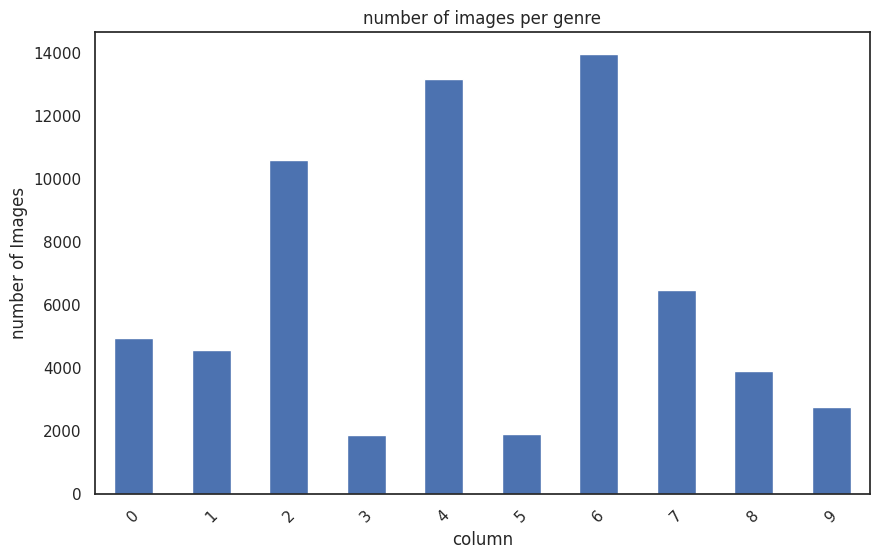

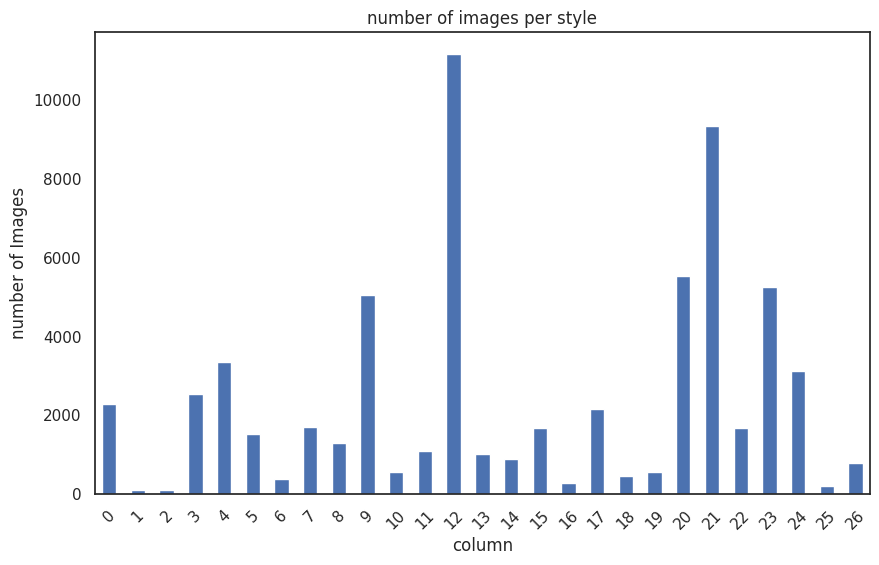

In [9]:
# Visualize the genres , styles distribution
def visualize_data(data_train,data_val,column,classes):
    combined_data = (data_train_cleaned[column].value_counts() + data_valid_cleaned[column].value_counts())
    combined_data.sort_index().plot(kind='bar', figsize=(10, 6), legend=False)
    plt.title(f"number of images per {column}")
    plt.ylabel("number of Images")
    plt.xlabel('column')
    plt.xticks(rotation=45)
    plt.show()
visualize_data(data_train_cleaned,data_valid_cleaned,'genre',genres_classes)
visualize_data(data_train_cleaned,data_valid_cleaned,'style',styles_classes)

In [10]:
# Split the data into training, validation and testing sets (80% train, 10% validation, 10% test)
genre_train_data, genre_data_temp = train_test_split(data_train_cleaned, test_size=0.30, random_state=42, stratify=data_train_cleaned['genre'])
genre_valid_data, genre_test_data = train_test_split(genre_data_temp, test_size=1/2, random_state=42, stratify=genre_data_temp['genre'])
print(genre_train_data.shape)
print(genre_valid_data.shape)
print(genre_test_data.shape)

(31407, 3)
(6730, 3)
(6731, 3)


In [11]:
# Split the data into training, validation and testing sets (80% train, 10% validation, 10% test)
style_train_data, style_data_temp = train_test_split(data_train_cleaned, test_size=0.30, random_state=42, stratify=data_train_cleaned['style'])
style_valid_data, style_test_data = train_test_split(style_data_temp, test_size=1/2, random_state=42, stratify=style_data_temp['style'])
print(style_train_data.shape)
print(style_valid_data.shape)
print(style_test_data.shape)

(31407, 3)
(6730, 3)
(6731, 3)


In [12]:
class Wikidataset(Dataset):
    def __init__(self, dataframe, root_dir, attribute, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.attribute = attribute
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]['filename'])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.dataframe.iloc[idx][self.attribute]
        label = torch.tensor(label, dtype=torch.int,)
        return image, label

In [13]:
img_size = 224  
IMAGE_NET_MEAN = [0.48145466, 0.4578275, 0.40821073]
IMAGE_NET_STD = [0.26862954, 0.26130258, 0.27577711]
normalize = transforms.Normalize(
    mean=IMAGE_NET_MEAN,
    std=IMAGE_NET_STD
)
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    normalize
])

valid_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    normalize
])
# Create datasets and dataloaders
genre_train_loader = DataLoader(Wikidataset(genre_train_data, datapath,'genre',transform=train_transform), batch_size=32, shuffle=True, num_workers=4)
genre_valid_loader = DataLoader(Wikidataset(genre_valid_data, datapath,'genre',transform=valid_transform), batch_size=32, shuffle=False, num_workers=4)
genre_test_loader = DataLoader(Wikidataset(genre_test_data, datapath,'genre',transform=valid_transform), batch_size=32, shuffle=False, num_workers=4)

style_train_loader = DataLoader(Wikidataset(style_train_data, datapath,'style',transform=train_transform), batch_size=32, shuffle=True, num_workers=4)
style_valid_loader = DataLoader(Wikidataset(style_valid_data, datapath,'style',transform=valid_transform), batch_size=32, shuffle=False, num_workers=4)
style_test_loader = DataLoader(Wikidataset(style_test_data, datapath,'style',transform=valid_transform), batch_size=32, shuffle=False, num_workers=4)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


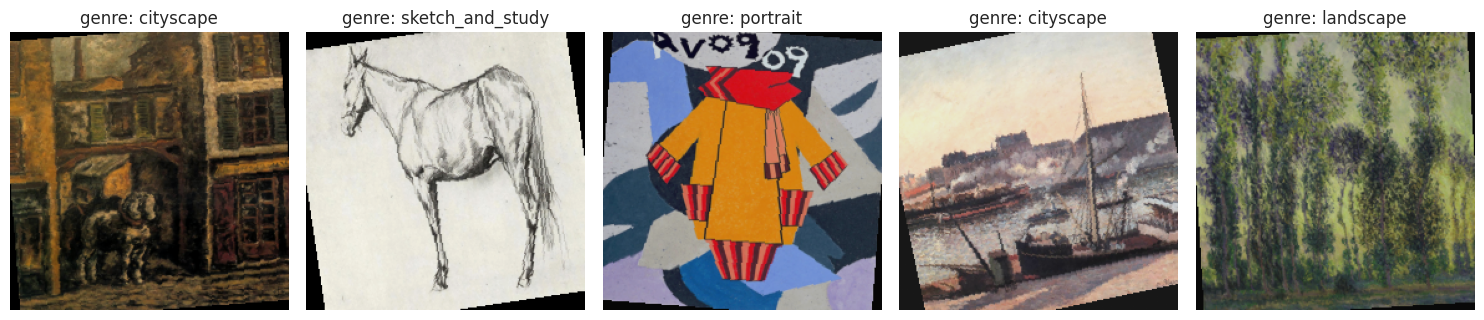

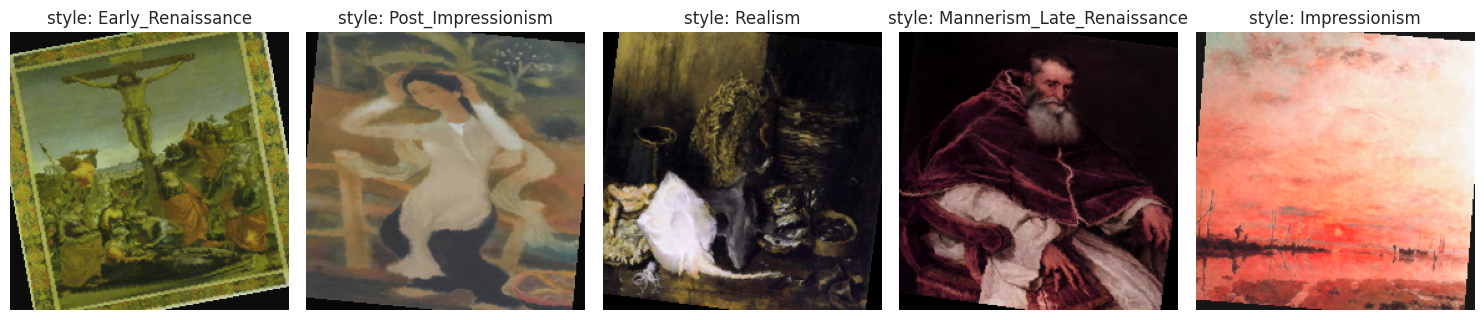

In [14]:
# Denormalize Before Displaying
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 1, 3)
    std = torch.tensor(std).view(1, 1, 3)
    if isinstance(tensor, np.ndarray):
      tensor = torch.tensor(tensor)
    return tensor * std + mean

# Visualize some training images
def visualize_train_loader(train_loader,attribute,classes):
  image, label = next(iter(train_loader))
  plt.figure(figsize=(15, 9))
  for i in range(5):
      plt.subplot(1, 5, i + 1)
      img = image[i].permute(1, 2, 0).numpy()      
      img = denormalize(img, IMAGE_NET_MEAN, IMAGE_NET_STD)
      img = img.numpy()
      plt.imshow(img)
      plt.title(f"{attribute}: {classes[label[i].item()]:}", fontsize=12)
      plt.axis('off')
  plt.tight_layout()
  plt.show()

visualize_train_loader(genre_train_loader,'genre',genres_classes)
visualize_train_loader(style_train_loader,'style',styles_classes)

In [15]:
# Clear Cache & Set Device
gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Multi-Model Architecture:

In [16]:
class MultiTaskClassifier(nn.Module):
    def __init__(self, model_name="convnext_base", num_genres=10, num_styles=27, drop_rate=0.1, drop_path_rate=0.1):
        super(MultiTaskClassifier, self).__init__()
        # backbone with no classifier head (num_classes=0) and global pooling ("avg")
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0, global_pool="avg")
        in_features = self.backbone.num_features
        # Two separate heads for each task
        self.genre_head = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(in_features, num_genres)
        )
        self.style_head = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(in_features, num_styles)
        )
    def forward(self, x):
        features = self.backbone(x)  # shape: (batch_size, in_features)
        genre_logits = self.genre_head(features)
        style_logits = self.style_head(features)
        return genre_logits, style_logits

model = MultiTaskClassifier(model_name="convnext_base", num_genres=10, num_styles=27, 
                            drop_rate=0.1, drop_path_rate=0.1)
model = nn.DataParallel(model) 
model.to(device)

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

DataParallel(
  (module): MultiTaskClassifier(
    (backbone): ConvNeXt(
      (stem): Sequential(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (stages): Sequential(
        (0): ConvNeXtStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): ConvNeXtBlock(
              (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
              (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=128, out_features=512, bias=True)
                (act): GELU()
                (drop1): Dropout(p=0.0, inplace=False)
                (norm): Identity()
                (fc2): Linear(in_features=512, out_features=128, bias=True)
                (drop2): Dropout(p=0.0, inplace=False)
              )
              (shortcut): Identity()
              (drop

In [17]:
print("Number of GPUs:", torch.cuda.device_count())

Number of GPUs: 2


In [18]:
# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
# Training Loop with Early Stopping
num_epochs = 10
patience = 3
trigger_times = 0

train_losses_genre, train_losses_style = [], []
val_losses_genre, val_losses_style = [], []
train_accs_genre, train_accs_style = [], []
val_accs_genre, val_accs_style = [], []
best_val_metric = 0.0

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    model.train()
    # ----- TRAIN: Genre -----
    running_loss_genre = 0.0
    correct_genre = 0
    total_genre = 0
    for images, labels in tqdm(genre_train_loader, desc='Genre Training'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        genre_logits, _ = model(images)
        loss_genre = criterion(genre_logits, labels.long())
        loss_genre.backward()
        optimizer.step()
        running_loss_genre += loss_genre.item() * images.size(0)
        _, predicted = torch.max(genre_logits, 1)
        correct_genre += (predicted == labels).sum().item()
        total_genre += labels.size(0)
    epoch_loss_genre = running_loss_genre / total_genre
    epoch_acc_genre = 100.0 * correct_genre / total_genre
    train_losses_genre.append(epoch_loss_genre)
    train_accs_genre.append(epoch_acc_genre)
    # ----- TRAIN: Style -----
    running_loss_style = 0.0
    correct_style = 0
    total_style = 0
    for images, labels in tqdm(style_train_loader, desc='Style Training'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        _, style_logits = model(images)
        loss_style = criterion(style_logits, labels.long())
        loss_style.backward()
        optimizer.step()
        running_loss_style += loss_style.item() * images.size(0)
        _, predicted = torch.max(style_logits, 1)
        correct_style += (predicted == labels).sum().item()
        total_style += labels.size(0)
    epoch_loss_style = running_loss_style / total_style
    epoch_acc_style = 100.0 * correct_style / total_style
    train_losses_style.append(epoch_loss_style)
    train_accs_style.append(epoch_acc_style)
    # ----- VALIDATION: Genre -----
    model.eval()
    val_loss_genre = 0.0
    val_correct_genre = 0
    val_total_genre = 0
    with torch.no_grad():
        for images, labels in tqdm(genre_valid_loader, desc='Genre Validation'):
            images, labels = images.to(device), labels.to(device)
            genre_logits, _ = model(images)
            loss = criterion(genre_logits, labels.long())
            val_loss_genre += loss.item() * images.size(0)
            _, predicted = torch.max(genre_logits, 1)
            val_correct_genre += (predicted == labels).sum().item()
            val_total_genre += labels.size(0)
    epoch_val_loss_genre = val_loss_genre / val_total_genre
    epoch_val_acc_genre = 100.0 * val_correct_genre / val_total_genre
    val_losses_genre.append(epoch_val_loss_genre)
    val_accs_genre.append(epoch_val_acc_genre)
    # ----- VALIDATION: Style -----
    val_loss_style = 0.0
    val_correct_style = 0
    val_total_style = 0
    with torch.no_grad():
        for images, labels in tqdm(style_valid_loader, desc='Style Validation'):
            images, labels = images.to(device), labels.to(device)
            _, style_logits = model(images)
            loss = criterion(style_logits, labels.long())
            val_loss_style += loss.item() * images.size(0)
            _, predicted = torch.max(style_logits, 1)
            val_correct_style += (predicted == labels).sum().item()
            val_total_style += labels.size(0)
    epoch_val_loss_style = val_loss_style / val_total_style
    epoch_val_acc_style = 100.0 * val_correct_style / val_total_style
    val_losses_style.append(epoch_val_loss_style)
    val_accs_style.append(epoch_val_acc_style)
    # Scheduler step (after both tasks training)
    scheduler.step()
    print(f"Genre - Train Loss: {epoch_loss_genre:.4f}, Train Acc: {epoch_acc_genre:.2f}% | Val Loss: {epoch_val_loss_genre:.4f}, Val Acc: {epoch_val_acc_genre:.2f}%")
    print(f"Style - Train Loss: {epoch_loss_style:.4f}, Train Acc: {epoch_acc_style:.2f}% | Val Loss: {epoch_val_loss_style:.4f}, Val Acc: {epoch_val_acc_style:.2f}%")
    # Combined metric: average of the two validation accuracies
    combined_val_metric = (epoch_val_acc_genre + epoch_val_acc_style) / 2
    if combined_val_metric > best_val_metric:
        best_val_metric = combined_val_metric
        torch.save(model.state_dict(), "genre_style_multi_model.pth")
        print("** Multitask model saved")
        trigger_times = 0  # reset early stopping counter
    else:
        trigger_times += 1
        print(f"No improvement for {trigger_times} epoch(s).")
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/10]


Genre Training:   0%|          | 0/982 [00:00<?, ?it/s]

Style Training:   0%|          | 0/982 [00:00<?, ?it/s]

Genre Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Style Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Genre - Train Loss: 0.6788, Train Acc: 76.65% | Val Loss: 1.0180, Val Acc: 65.01%
Style - Train Loss: 1.3321, Train Acc: 55.17% | Val Loss: 1.0564, Val Acc: 63.64%
** Multitask model saved
Epoch [2/10]


Genre Training:   0%|          | 0/982 [00:00<?, ?it/s]

Style Training:   0%|          | 0/982 [00:00<?, ?it/s]

Genre Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Style Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Genre - Train Loss: 0.4455, Train Acc: 84.34% | Val Loss: 0.6969, Val Acc: 76.57%
Style - Train Loss: 0.8104, Train Acc: 72.43% | Val Loss: 0.9720, Val Acc: 66.88%
** Multitask model saved
Epoch [3/10]


Genre Training:   0%|          | 0/982 [00:00<?, ?it/s]

Style Training:   0%|          | 0/982 [00:00<?, ?it/s]

Genre Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Style Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Genre - Train Loss: 0.2719, Train Acc: 90.55% | Val Loss: 0.6934, Val Acc: 76.55%
Style - Train Loss: 0.4303, Train Acc: 85.36% | Val Loss: 0.9921, Val Acc: 68.34%
** Multitask model saved
Epoch [4/10]


Genre Training:   0%|          | 0/982 [00:00<?, ?it/s]

Style Training:   0%|          | 0/982 [00:00<?, ?it/s]

Genre Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Style Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Genre - Train Loss: 0.1350, Train Acc: 95.78% | Val Loss: 0.7501, Val Acc: 75.72%
Style - Train Loss: 0.1758, Train Acc: 94.42% | Val Loss: 1.1423, Val Acc: 68.01%
No improvement for 1 epoch(s).
Epoch [5/10]


Genre Training:   0%|          | 0/982 [00:00<?, ?it/s]

Style Training:   0%|          | 0/982 [00:00<?, ?it/s]

Genre Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Style Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Genre - Train Loss: 0.0640, Train Acc: 98.01% | Val Loss: 0.7265, Val Acc: 78.05%
Style - Train Loss: 0.0786, Train Acc: 97.68% | Val Loss: 1.2762, Val Acc: 67.70%
** Multitask model saved
Epoch [6/10]


Genre Training:   0%|          | 0/982 [00:00<?, ?it/s]

Style Training:   0%|          | 0/982 [00:00<?, ?it/s]

Genre Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Style Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Genre - Train Loss: 0.0337, Train Acc: 99.13% | Val Loss: 0.7089, Val Acc: 79.32%
Style - Train Loss: 0.0399, Train Acc: 98.91% | Val Loss: 1.3426, Val Acc: 68.78%
** Multitask model saved
Epoch [7/10]


Genre Training:   0%|          | 0/982 [00:00<?, ?it/s]

Style Training:   0%|          | 0/982 [00:00<?, ?it/s]

Genre Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Style Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Genre - Train Loss: 0.0180, Train Acc: 99.54% | Val Loss: 0.7321, Val Acc: 80.46%
Style - Train Loss: 0.0206, Train Acc: 99.50% | Val Loss: 1.3290, Val Acc: 69.55%
** Multitask model saved
Epoch [8/10]


Genre Training:   0%|          | 0/982 [00:00<?, ?it/s]

Style Training:   0%|          | 0/982 [00:00<?, ?it/s]

Genre Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Style Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Genre - Train Loss: 0.0107, Train Acc: 99.75% | Val Loss: 0.7072, Val Acc: 81.80%
Style - Train Loss: 0.0090, Train Acc: 99.83% | Val Loss: 1.3807, Val Acc: 69.64%
** Multitask model saved
Epoch [9/10]


Genre Training:   0%|          | 0/982 [00:00<?, ?it/s]

Style Training:   0%|          | 0/982 [00:00<?, ?it/s]

Genre Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Style Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Genre - Train Loss: 0.0070, Train Acc: 99.89% | Val Loss: 0.7147, Val Acc: 82.29%
Style - Train Loss: 0.0056, Train Acc: 99.90% | Val Loss: 1.3833, Val Acc: 70.58%
** Multitask model saved
Epoch [10/10]


Genre Training:   0%|          | 0/982 [00:00<?, ?it/s]

Style Training:   0%|          | 0/982 [00:00<?, ?it/s]

Genre Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Style Validation:   0%|          | 0/211 [00:00<?, ?it/s]

Genre - Train Loss: 0.0062, Train Acc: 99.93% | Val Loss: 0.7268, Val Acc: 83.11%
Style - Train Loss: 0.0035, Train Acc: 99.97% | Val Loss: 1.3600, Val Acc: 70.49%
** Multitask model saved


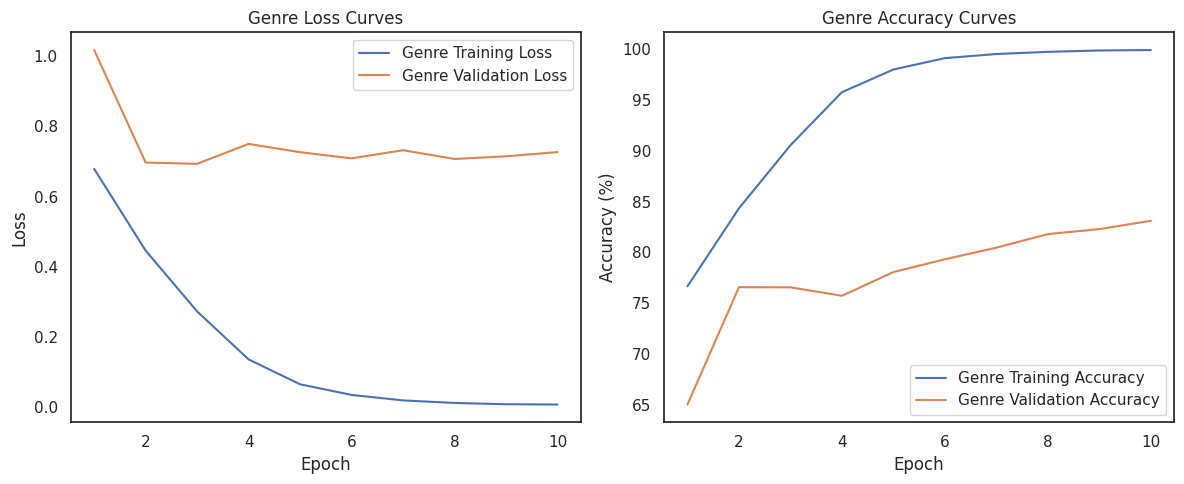

In [19]:
# Plotting Training Curves
epochs_genre = range(1, len(train_losses_genre) + 1)
plt.figure(figsize=(12, 5))
# Genre Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs_genre, train_losses_genre, label='Genre Training Loss')
plt.plot(epochs_genre, val_losses_genre, label='Genre Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Genre Loss Curves')
plt.legend()
# Genre Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs_genre, train_accs_genre, label='Genre Training Accuracy')
plt.plot(epochs_genre, val_accs_genre, label='Genre Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Genre Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.show()

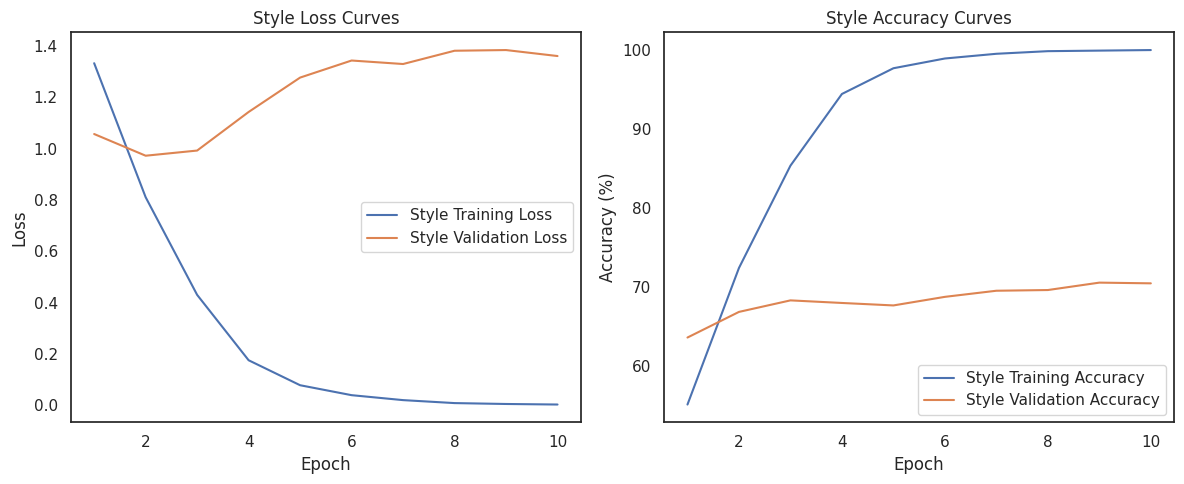

In [20]:
# ----- Style Training Curves -----
epochs_style = range(1, len(train_losses_style) + 1)
plt.figure(figsize=(12, 5))
# Style Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs_style, train_losses_style, label='Style Training Loss')
plt.plot(epochs_style, val_losses_style, label='Style Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Style Loss Curves')
plt.legend()
# Style Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs_style, train_accs_style, label='Style Training Accuracy')
plt.plot(epochs_style, val_accs_style, label='Style Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Style Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
model.eval()
test_correct_genre = 0
test_total_genre = 0
all_labels_genre = []
all_preds_genre = []
all_probs_genre = []
with torch.no_grad():
    for images, labels in tqdm(genre_test_loader, desc='Genre Test Loop'):
        images, labels = images.to(device), labels.to(device)
        # For genre, we take the first output from the model
        genre_logits, _ = model(images)
        probs = F.softmax(genre_logits, dim=1)
        _, preds = torch.max(genre_logits, 1)
        
        test_correct_genre += (preds == labels).sum().item()
        test_total_genre += labels.size(0)
        all_labels_genre.extend(labels.cpu().numpy())
        all_preds_genre.extend(preds.cpu().numpy())
        all_probs_genre.extend(probs.cpu().numpy())
all_labels_genre = np.array(all_labels_genre)
all_preds_genre = np.array(all_preds_genre)
all_probs_genre = np.array(all_probs_genre)
test_acc_genre = 100.0 * test_correct_genre / test_total_genre
print(f"Genre Test Accuracy: {test_acc_genre:.2f}%")
# ----- Genre Classification Report -----
genres_names = [genres_classes[i] for i in sorted(genres_classes.keys())]
report_genre = classification_report(all_labels_genre, all_preds_genre, target_names=genres_names)
print("Genre Classification Report:")
print(report_genre)

Genre Test Loop:   0%|          | 0/211 [00:00<?, ?it/s]

Genre Test Accuracy: 82.66%
Genre Classification Report:
                    precision    recall  f1-score   support

 abstract_painting       0.95      0.96      0.95       518
         cityscape       0.82      0.73      0.77       477
    genre_painting       0.71      0.75      0.73      1111
      illustration       0.77      0.74      0.76       197
         landscape       0.86      0.90      0.88      1382
     nude_painting       0.77      0.64      0.70       201
          portrait       0.86      0.86      0.86      1464
religious_painting       0.85      0.85      0.85       680
  sketch_and_study       0.72      0.64      0.68       409
        still_life       0.86      0.89      0.88       292

          accuracy                           0.83      6731
         macro avg       0.82      0.80      0.81      6731
      weighted avg       0.83      0.83      0.83      6731



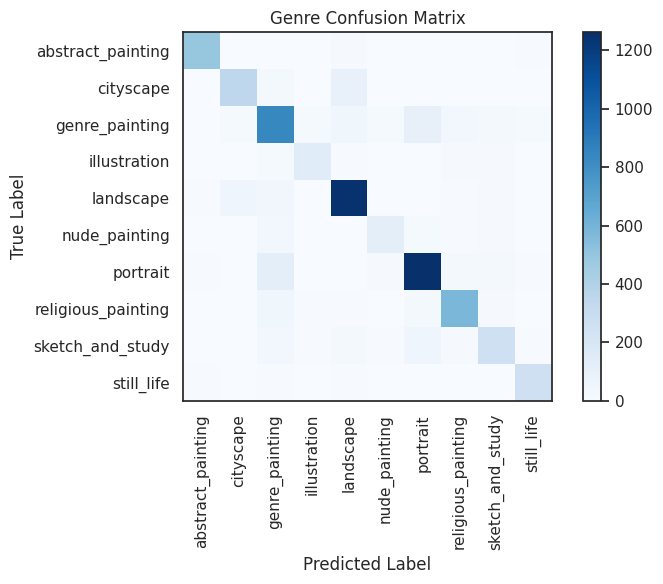

In [22]:
# ----- Genre Confusion Matrix -----
cm_genre = confusion_matrix(all_labels_genre, all_preds_genre)
plt.figure(figsize=(8, 6))
plt.imshow(cm_genre, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Genre Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(genres_names))
plt.xticks(tick_marks, genres_names, rotation=90)
plt.yticks(tick_marks, genres_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

<ipython-input-23-5c167a841da8>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


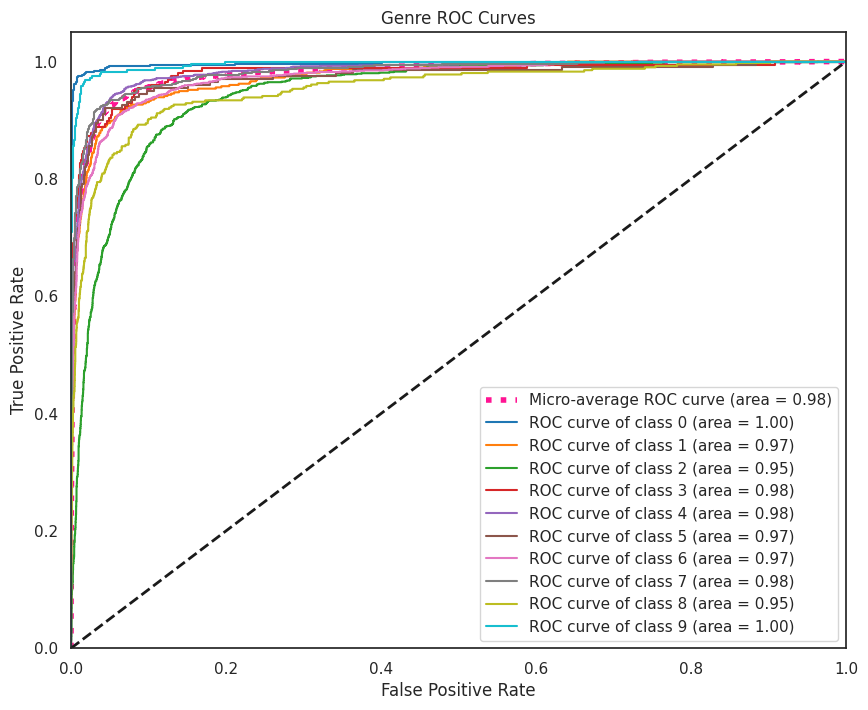

In [23]:
# ----- Genre ROC Curves and ROC-AUC -----
n_classes = 10  # Adjust if needed
# Binarize the labels
all_labels_bin_genre = label_binarize(all_labels_genre, classes=np.arange(n_classes))

fpr_genre, tpr_genre, roc_auc_genre = dict(), dict(), dict()
for i in range(n_classes):
    fpr_genre[i], tpr_genre[i], _ = roc_curve(all_labels_bin_genre[:, i], all_probs_genre[:, i])
    roc_auc_genre[i] = auc(fpr_genre[i], tpr_genre[i])

fpr_genre["micro"], tpr_genre["micro"], _ = roc_curve(all_labels_bin_genre.ravel(), all_probs_genre.ravel())
roc_auc_genre["micro"] = auc(fpr_genre["micro"], tpr_genre["micro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr_genre["micro"], tpr_genre["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_genre["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
colors = plt.cm.get_cmap('tab10')
for i in range(n_classes):
    plt.plot(fpr_genre[i], tpr_genre[i], color=colors(i),
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_genre[i])) 
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Genre ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [24]:
# Test Evaluation for Style Task
test_correct_style = 0
test_total_style = 0
all_labels_style = []
all_preds_style = []
all_probs_style = []
with torch.no_grad():
    for images, labels in tqdm(style_test_loader, desc='Style Test Loop'):
        images, labels = images.to(device), labels.to(device)
        # For style, we take the second output from the model
        _, style_logits = model(images)
        probs = F.softmax(style_logits, dim=1)
        _, preds = torch.max(style_logits, 1)
        
        test_correct_style += (preds == labels).sum().item()
        test_total_style += labels.size(0)
        all_labels_style.extend(labels.cpu().numpy())
        all_preds_style.extend(preds.cpu().numpy())
        all_probs_style.extend(probs.cpu().numpy())
all_labels_style = np.array(all_labels_style)
all_preds_style = np.array(all_preds_style)
all_probs_style = np.array(all_probs_style)

test_acc_style = 100.0 * test_correct_style / test_total_style
print(f"Style Test Accuracy: {test_acc_style:.2f}%")

# ----- Style Classification Report -----
styles_names = [styles_classes[i] for i in sorted(styles_classes.keys())]
report_style = classification_report(all_labels_style, all_preds_style, target_names=styles_names)
print("Style Classification Report:")
print(report_style)

Style Test Loop:   0%|          | 0/211 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Style Test Accuracy: 69.48%
Style Classification Report:
                            precision    recall  f1-score   support

    Abstract_Expressionism       0.82      0.85      0.84       240
           Action_painting       1.00      0.40      0.57        10
         Analytical_Cubism       0.78      0.64      0.70        11
               Art_Nouveau       0.65      0.61      0.63       266
                   Baroque       0.76      0.73      0.74       355
      Color_Field_Painting       0.81      0.78      0.79       159
      Contemporary_Realism       0.86      0.46      0.60        39
                    Cubism       0.67      0.66      0.67       178
         Early_Renaissance       0.81      0.78      0.79       136
             Expressionism       0.60      0.61      0.61       531
                   Fauvism       0.63      0.33      0.44        57
          High_Renaissance       0.58      0.56      0.57       117
             Impressionism       0.75      0.76      0.76 

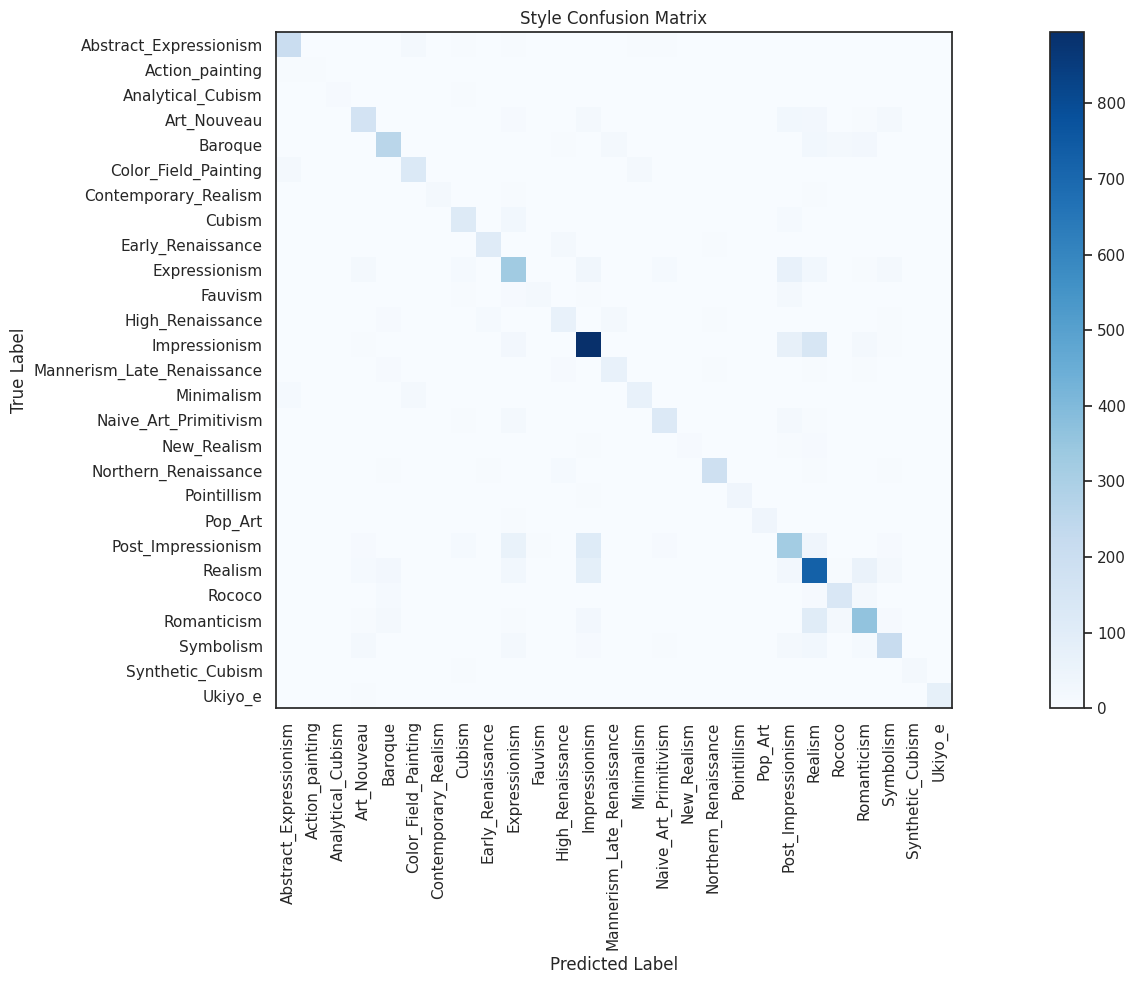

In [25]:
# ----- Style Confusion Matrix -----
cm_style = confusion_matrix(all_labels_style, all_preds_style)
plt.figure(figsize=(20, 10))
plt.imshow(cm_style, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Style Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(styles_names))
plt.xticks(tick_marks, styles_names, rotation=90)
plt.yticks(tick_marks, styles_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

<ipython-input-26-0f386f5c5117>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


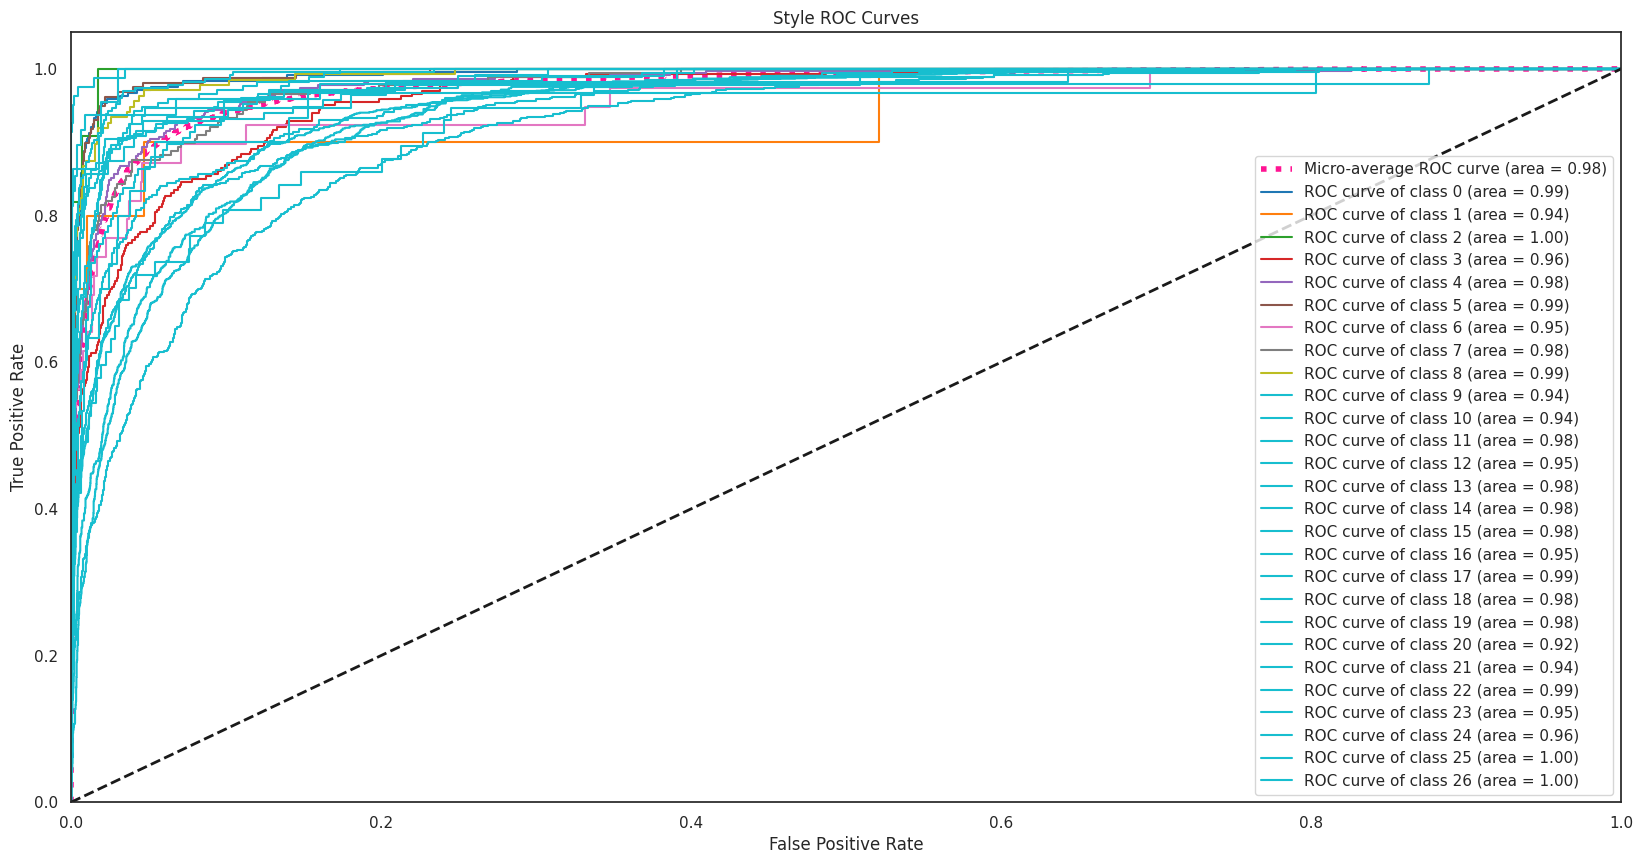

In [26]:
# ----- Style ROC Curves and ROC-AUC -----
n_classes = 27
all_labels_bin_style = label_binarize(all_labels_style, classes=np.arange(n_classes))
fpr_style, tpr_style, roc_auc_style = dict(), dict(), dict()
for i in range(n_classes):
    fpr_style[i], tpr_style[i], _ = roc_curve(all_labels_bin_style[:, i], all_probs_style[:, i])
    roc_auc_style[i] = auc(fpr_style[i], tpr_style[i])

fpr_style["micro"], tpr_style["micro"], _ = roc_curve(all_labels_bin_style.ravel(), all_probs_style.ravel())
roc_auc_style["micro"] = auc(fpr_style["micro"], tpr_style["micro"])

plt.figure(figsize=(20, 10))
plt.plot(fpr_style["micro"], tpr_style["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_style["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
colors = plt.cm.get_cmap('tab10')
for i in range(n_classes):
    plt.plot(fpr_style[i], tpr_style[i], color=colors(i),
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_style[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Style ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [27]:
import json
with open('/kaggle/working/style_classes.json', 'w') as f:
    json.dump(styles_classes, f)
with open('/kaggle/working/genre_classes.json', 'w') as f:
    json.dump(genres_classes, f)